# Intro

The notebook ccontains a simple check for co-occurrence learning method. You can see [models_gaussian_A.py](models_gaussian_A.py) working.

In [35]:
import numpy as np
import itertools
from hmmlearn import hmm
from models_gaussian_A import GaussianDenseHMM, HMMLoggingMonitor
import time
from tqdm import tqdm
from ssm.util import find_permutation
import pickle
import json
from pathlib import Path
import wandb
from utils import dtv, permute_embeddings, compute_stationary,  empirical_coocs
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.special import erf
from sklearn.cluster import KMeans
from eval_utils import *

In [36]:
np.random.seed(2022)

simple_model_params = {"mu": 10,
                "sigma": 1}

complicated_model_params = {"mu": 5,
                     "sigma": 2}

dsize = (100, 400, 4)  # (s, T, n) TODO:  fill

EM_ITER = 20
l = 8
simple_model=True
ITER = 10000
TOLERANCE = 1e-4

In [40]:
def em_scheduler(max_lr, it):
    if it <= np.ceil(ITER / 3):
        return max_lr * np.cos(3 * (np.ceil(ITER / 3) - it) * np.pi * .33 / ITER)
    else:
        return max_lr * np.cos((it - np.ceil(ITER / 3)) * np.pi * .66 / ITER)  ** 2

mstep_cofig = {"cooc_lr": 0.1, "cooc_epochs": ITER, "l_uz": 10,
               'loss_type': 'square', "scheduler": em_scheduler}

s, T, n, pi, A, mu, sigma, result, true_values, wandb_params, X_true, Y_true, lengths, data, em_scheduler = init_experiment(dsize=dsize, simple_model=simple_model)

In [41]:
t = time.localtime()

true_values = {
    "states": X_true,
    "transmat": A,
    "startprob": pi,
    "means": mu,
    "covars": sigma
}

wandb_params = {
    "init": {
        "project": "gaussian-dense-hmm",
        "entity": "cirglaboratory",
        "save_code": True,
        "group": f"benchmark-{t.tm_year}-{t.tm_mon}-{t.tm_mday}-debug3",
        "job_type": f"n={n}-s={s}-T={T}-simple={simple_model}",
        "name": f"PDFs",
        "reinit": True
    },
    "config": {
        "n": n,
        "s": s,
        "T": T,
        "model": None,
        "m": None,
        "l": None,
        "lr":  0,
        "em_epochs":  0,
        "em_iter": EM_ITER,
        "cooc_epochs": ITER,
        "epochs": 0,
        "simple_model": simple_model
    }
}

wandb.init(**wandb_params["init"], config=wandb_params["config"])

wandb_params["init"].update({"job_type": f"n={n}-s={s}-T={s}-simple={simple_model}",
                             "name": f"dense--l={l}-lr={mstep_cofig['cooc_lr']}-epochs={mstep_cofig['cooc_epochs']}-{time.asctime()}"})
wandb_params["config"].update(dict(model="dense_cooc_em_penalty", m=n, l=l, lr=mstep_cofig['cooc_lr'], em_epochs=10,
                                   em_iter=EM_ITER, cooc_epochs=mstep_cofig['cooc_epochs'], epochs=mstep_cofig['cooc_epochs'],
                                   loss_type='square', scheduler=True))

# wandb.init(**wandb_params["init"], config=wandb_params["config"])


accuracy,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
startprob_dtv,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
time,▁▁▁▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇███
total_log_prob,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
transmat_dtv,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
accuracy,0.32785
covars_mae,nan
means_mae,nan
omage_dtv,nan
startprob_dtv,0.02942
time,65.74634


In [42]:
nodes_tmp = mu.reshape(-1)
nodes = np.concatenate([(nodes_tmp[1:] + nodes_tmp[:-1]) / 2, np.array([np.infty])])
Y_disc =  (Y_true > nodes.reshape(1, -1)).sum(axis=-1).reshape(-1, 1)
# Y_disc, nodes = to_discrete(Y_true, m=n)

In [43]:
nodes

array([ 5., 15., 25., inf])

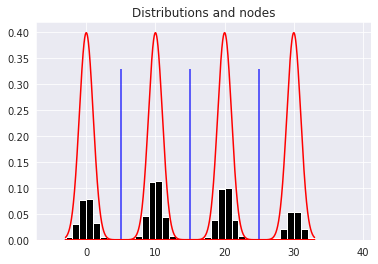

In [44]:
# Y_disc, nodes = to_discrete_q(Y_true, m=4)

plt.vlines(nodes, np.zeros(nodes.shape), np.ones(nodes.shape) * 0.33, color="blue", alpha = 0.8)
plt.hist(Y_true, bins=[i for i in range(-5, n*10)], color="black", density=True)
x = np.linspace(min(mu) - 3 * max(sigma), max(mu) + 3*max(sigma), 10000)
for i in range(n):
    plt.plot(x, stats.norm.pdf(x, mu[i], sigma[i]), label=str(i), color="red")
plt.title("Distributions and nodes")
plt.show()

In [45]:
omega_emp = empirical_cooc_prob(Y_disc, n, lengths)

In [46]:
omega_gt = normal_cooc_prob(mu, sigma, nodes, A)

In [47]:
# omega_emp = np.exp(omega_emp)
# omega_gt = np.exp(omega_gt)

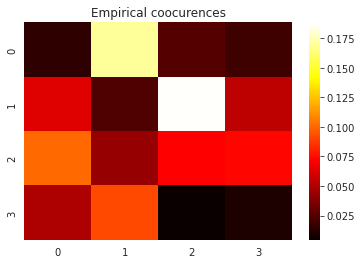

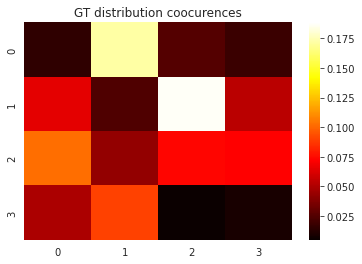

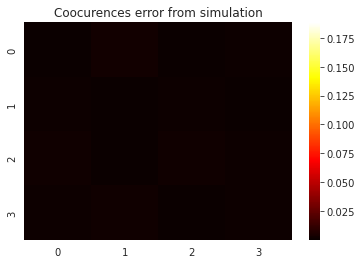

In [48]:
vmax = max(omega_emp.max(), omega_gt.max(), (omega_emp - omega_gt).max()) +  1e-3
visualize_matrix(omega_emp, title="Empirical coocurences", vmax=vmax)
visualize_matrix(omega_gt, title="GT distribution coocurences",  vmax=vmax)
visualize_matrix(abs(omega_gt - omega_emp), title="Coocurences error from simulation", vmax=vmax)

In [49]:
print("MAPE:",  round(abs((omega_gt - omega_emp) / omega_gt).mean()  * 100, 1),  "%")

MAPE: 2.5 %


In [50]:
summary = []
# TODO: you can change model parameters
for  _  in range(4):
    mstep_cofig = {"cooc_lr": 0.1, "cooc_epochs": ITER, "l_uz": n // 2,
               "em_lr":  0.01, "em_epochs":20, 'loss_type': 'square', "scheduler": em_scheduler}
    wandb_params["init"].update({"name": f"dense--l={l}-lr={mstep_cofig['cooc_lr']}-epochs={mstep_cofig['cooc_epochs']}-{time.asctime()}"})
    hmm_monitor = HMMLoggingMonitor(tol=TOLERANCE, n_iter=0, verbose=False,
                                    wandb_log=True, wandb_params=wandb_params, true_vals=true_values,
                                    log_config={'metrics_after_convergence': True})
    densehmm = GaussianDenseHMM(n, mstep_config=mstep_cofig,
                                covariance_type='diag', opt_schemes={"cooc"},
                                nodes=np.concatenate([np.array([-np.infty]), nodes]),
                                discrete_observables=n, em_iter=20,
                                logging_monitor=hmm_monitor, verbose=False,
                                init_params="", params="stmc", early_stopping=True)
    densehmm.means_ = mu.reshape(-1, 1)
    start = time.perf_counter()
    densehmm.fit_coocs(Y_true, lengths)
    # densehmm.fit(Y_true, lengths)  # TODO: you  can also use fit_coocs as initialization for EM
    summary.append(
        {
            "time": time.perf_counter() - start,
            "acc":  hmm_monitor.accuracy[-1],
            "log_prob":  hmm_monitor.history[-1]
        }
    )
    time_tmp = time.perf_counter() - start
display(summary)

accuracy,▁▁▁▁▁▁▁▁▁▁
covars_mae,▁▂▂▃▅▆▇███
means_mae,███▁▁▁▂▂▂▂
omage_dtv,█▃▃▂▂▁▁▁▁▁
startprob_dtv,▄▅▄▁▆███▇▇
time,▁▂▃▃▄▅▆▆▇█
total_log_prob,▁▃▄▆▇█████
transmat_dtv,▁▅▅▄▆▇▇▇██
accuracy,0.32775
covars_mae,10.75949
means_mae,0.77764


accuracy,██▇▆▄▄▃▂▁▁
covars_mae,▁▃▄▆▆▇▇███
means_mae,█▇▆▄▃▃▂▁▁▁
omage_dtv,█▃▂▂▁▁▁▁▁▁
startprob_dtv,▁▁▁▁▁▁▁▁▁▁
time,▁▂▃▃▄▅▆▆▇█
total_log_prob,▁▆▇▇▇█████
transmat_dtv,▁▁▁▁▁▁▄▆▇█
accuracy,0.45677
covars_mae,23.24187
means_mae,9.36902


accuracy,▁▁▁▁▁▁▁▁▁▁
covars_mae,▁▁▂▄▆▆▇███
means_mae,██▁▁▂▂▂▂▂▂
omage_dtv,█▇▆▅▃▂▁▁▁▁
startprob_dtv,▁▃▄▆▇█████
time,▁▂▃▃▄▅▆▆▇█
total_log_prob,▁▂▆▇██████
transmat_dtv,▇█▁▂▂▂▃▃▃▃
accuracy,0.32775
covars_mae,20.05227
means_mae,1.07017


[{'time': 15.697883492335677, 'acc': 0.32775, 'log_prob': -716745.5230418318},
 {'time': 15.134998795110732, 'acc': 0.456775, 'log_prob': -23035066.06813948},
 {'time': 15.323562363162637, 'acc': 0.32775, 'log_prob': -372433.2730850221},
 {'time': 15.97201467398554, 'acc': 0.39815, 'log_prob': -13012473.493775174}]

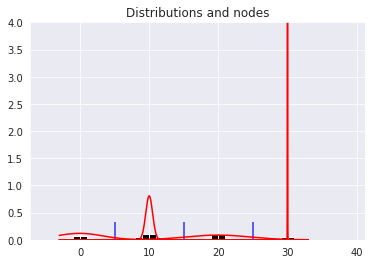

In [55]:
plt.vlines(nodes, np.zeros(nodes.shape), np.ones(nodes.shape) * 0.33, color="blue", alpha = 0.8)
plt.hist(Y_true, bins=[i for i in range(-5,  n*10)], color="black", density=True)
x = np.linspace(min(mu) - 3 * max(sigma), max(mu) + 3*max(sigma), 10000).reshape(-1)
for i in range(n):
    plt.plot(x, stats.norm.pdf(x, densehmm.means_.reshape(-1)[i], densehmm.covars_.reshape(-1)[i]).reshape(-1), label=str(i), color="red")
plt.title("Distributions and nodes")
plt.ylim(0, 4)
plt.show()